In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd 
from pathlib import Path
from bioblp.data import COL_EDGE, COL_SOURCE, COL_TARGET

/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR = Path("../data")
SHARED_DIR = Path("/home/jovyan/workbench-shared-folder/bioblp")

In [4]:
!ls {SHARED_DIR}/models

1baon0eg  iwy9z7m9


## Load benchmark

In [5]:
dpi_benchmark_path = SHARED_DIR.joinpath('data/benchmarks/dpi_fda.tsv') 

In [6]:
dpi_bm = pd.read_csv(dpi_benchmark_path, sep='\t', names=[COL_SOURCE, COL_EDGE, COL_TARGET])
dpi_bm.head(3)

,src,edg,tgt
0,DB01079,DPI,Q13639
1,DB00114,DPI,P20711
2,DB01158,DPI,P13637



* [DB01079; Tegaserod](https://go.drugbank.com/drugs/DB01079)
Tegaserod is a serotonin-4 (5-HT4) receptor agonist indicated for the treatment of constipation predominant irritable bowel syndrome (IBS-C) specifically in women under the age of 65. There is currently no safety or efficacy data for use of tegaserol in men.

* https://www.uniprot.org/uniprotkb/Q13639/entry

In [7]:
dpi_drugs_unique = list(dpi_bm.src.unique())
dpi_prots_unique = list(dpi_bm.tgt.unique())
print(f'# total dpi instances (TP): {len(dpi_bm)}')
print(f'# Unique Drugs: {len(dpi_drugs_unique)}')
print(f'# Unique Proteins: {len(dpi_prots_unique)}')


# total dpi instances (TP): 19161
# Unique Drugs: 2286
# Unique Proteins: 2705


## Prepare Data for ML

In [8]:
from bioblp.benchmarking.featurize import load_model_and_entity_to_id_maps, ENTITY_TO_ID_MAP, RELATION_TO_ID_MAP

In [9]:
model_dir = SHARED_DIR.joinpath('models/1baon0eg')
model_dir_best = SHARED_DIR.joinpath('models/iwy9z7m9')
kge_artifacts = load_model_and_entity_to_id_maps(model_dir_best)
entity_to_id_map = kge_artifacts.get(ENTITY_TO_ID_MAP)
relation_to_id_map = kge_artifacts.get(RELATION_TO_ID_MAP)


09:40:39 - INFO - bioblp.benchmarking.featurize - Loading trained model from /home/jovyan/workbench-shared-folder/bioblp/models/iwy9z7m9


### Generate Negative samples

In [10]:
from bioblp.benchmarking.preprocess import prepare_dpi_samples

In [11]:
import numpy as np
dpi_bm = pd.read_csv(dpi_benchmark_path, sep='\t', names=[COL_SOURCE, COL_EDGE, COL_TARGET])
dpi_bm['src_id'] = dpi_bm['src'].map(lambda x: entity_to_id_map.get(x, np.nan))
dpi_bm['tgt_id'] = dpi_bm['tgt'].map(lambda x: entity_to_id_map.get(x, np.nan))

In [12]:
dpi_bm[dpi_bm.src_id.isnull() | dpi_bm.tgt_id.isnull()]

,src,edg,tgt,src_id,tgt_id
13,DB11660,DPI,O94956,NaN,25006.0
20,DB02893,DPI,P50579,NaN,36593.0
55,DB13998,DPI,P27824,NaN,31868.0
68,DB04209,DPI,P98170,NaN,40638.0
143,DB10770,DPI,P17948,NaN,29952.0
...,...,...,...,...,...
18835,DB01030,DPI,Q969P6,8815.0,NaN
18854,DB13893,DPI,P22413,NaN,30855.0
18920,DB01369,DPI,P61177,9113.0,NaN
18983,DB12010,DPI,Q8N568,14924.0,NaN


In [13]:
dpi_bm_transd = dpi_bm[~(dpi_bm.src_id.isnull() | dpi_bm.tgt_id.isnull())]

In [14]:
len(dpi_bm_transd) -len(dpi_bm)

-483

In [15]:
pos_neg_df = prepare_dpi_samples(dpi_bm_transd, entity_to_id_map, relation_to_id_map)

In [16]:
len(pos_neg_df)

37356

In [17]:
pos_neg_df.head(3)

,src,edg,tgt,src_id,tgt_id,label
0,8861,5,44147,8861.0,44147.0,1
1,7916,5,30505,7916.0,30505.0,1
2,8938,5,29091,8938.0,29091.0,1


### Featurize by obtaining joint entity pair encoding

In [18]:
from bioblp.benchmarking.featurize import generate_entity_pair_joint_encoding
from bioblp.benchmarking.featurize import concatenate, average


In [19]:
# pass on to KGEM encoder to featurize each entity pair
encoded_df = generate_entity_pair_joint_encoding(pos_neg_df,
                                    model=kge_artifacts["model"],
                                    transform_fn=concatenate)

encoded_df['joint_encoding'] = encoded_df['joint_encoding'].apply(lambda x: np.asarray(x).reshape(-1, 1))


09:40:42 - INFO - bioblp.benchmarking.featurize - Applying transformation function: f<function concatenate at 0x7f68f8b92040>, to retrieve joint encoding for entity pair


In [20]:
encoded_df.loc[0, 'joint_encoding'].shape

(1024, 1)

## Train ML model for binary clf

In [21]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(encoded_df.loc[:, 'joint_encoding'], encoded_df['label'], test_size=0.1, 
                                                    random_state=0, shuffle=True)

In [22]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        dpi_enc_tensor = torch.from_numpy(self.X[idx]).view(1, -1).float()
        dpi_label = torch.tensor(self.y[idx].ravel()).float().unsqueeze(1)
        return dpi_enc_tensor, dpi_label


In [23]:
from torch.utils.data import random_split
dataset = CustomDataset(encoded_df.joint_encoding.values, encoded_df.label.values)
test_prop = 0.1
test_size = int(0.1*len(dataset))
train_size = len(dataset)-test_size
test_size, len(dataset)

(3735, 37356)

In [24]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=10)

print("The length of train data is:",len(train_dataset))
print("The length of test data is:",len(test_dataset))

The length of train data is: 33621
The length of test data is: 3735


In [25]:
train_dataset.__getitem__(3)[0].shape

torch.Size([1, 1024])

In [26]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128,32),
            nn.ReLU(),
            nn.Linear(32,1),
            #nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)
    
    

In [32]:
torch.manual_seed(2022)

# intialize MLP
mlp = MLP()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [33]:
# Run the training loop
train_losses = []
test_losses = []
for epoch in range(20):
    print(f"Starting epoch {epoch}")    
    current_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        
        inputs, targets = data
        targets = targets
        optimizer.zero_grad()
        outputs = mlp(inputs)
        
        loss = loss_function(outputs, targets)
        loss.backward()
        current_loss+=loss
        optimizer.step()
        """
        if i%1000 == 999:
            print(f'Loss after mini batch: {i+1}: {current_loss/1000}')
            current_loss = 0.0
        """
    print("Loss in iteration :"+str(epoch)+" is: "+str(loss.item()))
    train_losses.append(loss.item())       
    # compute test loss
    with torch.no_grad():
        for xb_test, yb_test in test_loader:
            test_preds = mlp(xb_test)
            test_loss = loss_function(test_preds, yb_test)
        test_losses.append(test_loss.item())
    
        

Starting epoch 0
Loss in iteration :0 is: 0.11026746034622192
Starting epoch 1
Loss in iteration :1 is: 0.0014156806282699108
Starting epoch 2
Loss in iteration :2 is: 0.00806681253015995
Starting epoch 3
Loss in iteration :3 is: 0.0015448314370587468
Starting epoch 4
Loss in iteration :4 is: 0.0013910388806834817
Starting epoch 5
Loss in iteration :5 is: 0.0
Starting epoch 6
Loss in iteration :6 is: 7.510157047363464e-06
Starting epoch 7
Loss in iteration :7 is: 0.0
Starting epoch 8
Loss in iteration :8 is: 0.026104889810085297
Starting epoch 9
Loss in iteration :9 is: 0.0
Starting epoch 10
Loss in iteration :10 is: 0.0
Starting epoch 11
Loss in iteration :11 is: 0.0
Starting epoch 12
Loss in iteration :12 is: 0.0
Starting epoch 13
Loss in iteration :13 is: 0.002746859099715948
Starting epoch 14
Loss in iteration :14 is: 0.0
Starting epoch 15
Loss in iteration :15 is: 0.0
Starting epoch 16
Loss in iteration :16 is: 0.0
Starting epoch 17
Loss in iteration :17 is: 1.1920928244535389e-07

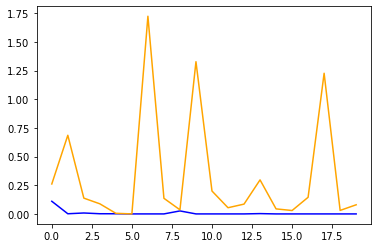

In [36]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train loss', color='blue')
plt.plot(test_losses, label='test loss', color='orange')
plt.show()

In [117]:
# predictions
import itertools

y_pred_list = []
test_acc_list = []
y_true_list = []
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_pred = mlp(xb_test)
        y_pred_tag = (y_pred.detach().numpy()>0)
        acc_test = np.mean(y_pred_tag==yb_test.numpy())
        print(y_pred_tag, yb_test.numpy(), acc_test)
        y_pred_list.append(y_pred_tag)
        test_acc_list.append(acc_test) 
        y_true_list.append(yb_test.detach().squeeze().tolist())
        #print(yb_test, y_pred_tag, acc_test)
      
np.mean(test_acc_list)

[[[False]]

 [[False]]

 [[ True]]

 [[ True]]

 [[False]]

 [[False]]

 [[ True]]

 [[False]]

 [[ True]]

 [[False]]] [[[0.]]

 [[0.]]

 [[1.]]

 [[1.]]

 [[0.]]

 [[0.]]

 [[1.]]

 [[0.]]

 [[1.]]

 [[0.]]] 1.0
[[[ True]]

 [[ True]]

 [[ True]]

 [[ True]]

 [[False]]

 [[ True]]

 [[False]]

 [[False]]

 [[False]]

 [[ True]]] [[[1.]]

 [[1.]]

 [[1.]]

 [[1.]]

 [[0.]]

 [[1.]]

 [[0.]]

 [[0.]]

 [[0.]]

 [[1.]]] 1.0
[[[ True]]

 [[False]]

 [[ True]]

 [[ True]]

 [[False]]

 [[ True]]

 [[ True]]

 [[False]]

 [[False]]

 [[False]]] [[[1.]]

 [[0.]]

 [[1.]]

 [[1.]]

 [[0.]]

 [[1.]]

 [[1.]]

 [[0.]]

 [[0.]]

 [[0.]]] 1.0
[[[False]]

 [[False]]

 [[False]]

 [[False]]

 [[ True]]

 [[False]]

 [[False]]

 [[ True]]

 [[False]]

 [[False]]] [[[1.]]

 [[0.]]

 [[1.]]

 [[0.]]

 [[1.]]

 [[0.]]

 [[0.]]

 [[1.]]

 [[1.]]

 [[0.]]] 0.7
[[[False]]

 [[False]]

 [[False]]

 [[ True]]

 [[ True]]

 [[False]]

 [[False]]

 [[ True]]

 [[False]]

 [[False]]] [[[0.]]

 [[0.]]

 [[0.]

0.9050802139037435

In [119]:
#Takes arrays and makes them list of list for each batch        
y_pred_list_ = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list_))
ytest_pred = [float(x) for x in ytest_pred]
len(ytest_pred)

3735

In [126]:
ytest_true = list(itertools.chain.from_iterable(y_true_list))
ytest_true[:10]

[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [128]:
np.mean(np.asarray(ytest_true) == np.asarray(ytest_pred))

0.9049531459170014

In [133]:
test_accuracy = np.mean(np.asarray(ytest_true)== np.asarray(ytest_pred))
test_accuracy

0.9049531459170014

#### confusion matrix

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [130]:
print(metrics.classification_report(ytest_true, ytest_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91      1869
         1.0       0.94      0.87      0.90      1866

    accuracy                           0.90      3735
   macro avg       0.91      0.90      0.90      3735
weighted avg       0.91      0.90      0.90      3735



In [131]:
cm = metrics.confusion_matrix(ytest_true, ytest_pred)
print(cm)

[[1759  110]
 [ 245 1621]]


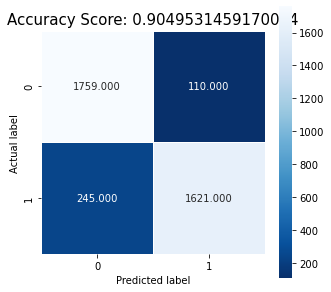

In [135]:
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(test_accuracy)
plt.title(all_sample_title, size = 15);

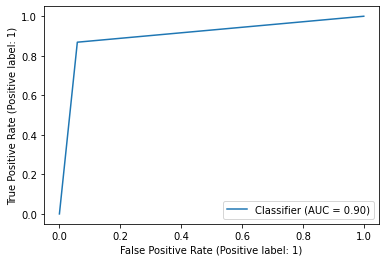

In [137]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(ytest_true, ytest_pred)
plt.show()

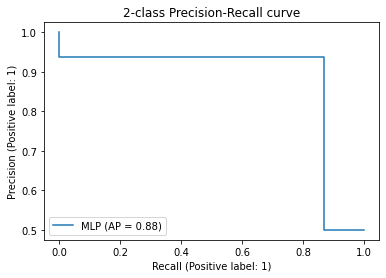

In [140]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(
    ytest_true, ytest_pred, name="MLP"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [74]:
df = pd.DataFrame(dict(name=['Raphael', 'Donatello'],
                  mask=['red', 'purple'],
                  weapon=['sai', 'bo staff']))
print(df.to_latex(index=False)) 

\begin{tabular}{lll}
\toprule
     name &   mask &   weapon \\
\midrule
  Raphael &    red &      sai \\
Donatello & purple & bo staff \\
\bottomrule
\end{tabular}



/tmp/ipykernel_150/3013256967.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False))


In [75]:
df


,name,mask,weapon
0,Raphael,red,sai
1,Donatello,purple,bo staff
